In [ ]:
# upload in file space all pca data inside a pca folder
# upload in file space video categories.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # /content/drive/MyDrive/neuromatch

Mounted at /content/drive


In [ ]:
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, spearmanr

In [ ]:
train, test = {},{}
for i in range(8):
    train[f'layer_{i+1}'] = np.load(f"/content/drive/MyDrive/neuromatch/pca_100_380videos/train_layer_{i+1}.npy")
    test[f'layer_{i+1}'] = np.load(f"/content/drive/MyDrive/neuromatch/pca_100_380videos/test_layer_{i+1}.npy")

In [ ]:
# this loads result from AlexNet Classification (with LLM reduction)
classes = pd.read_csv('/content/drive/MyDrive/neuromatch/NEW 380 video cats.csv', header=0)
classes['video_path'] = classes['video_id']
classes['video_id'] = classes['video_id'].str.split("/").str.get(3)
classes = classes[classes['index'] <= 1000]
classes['feat_index'] = classes['index'] + 1
dicty = classes[['feat_index','llm_classes']]

In [ ]:
filtered_train = {}
for layer, activation_weights in train.items():
    each_layer_df = pd.DataFrame(activation_weights).reset_index()
    each_layer_df['index'] = each_layer_df['index']+1
    each_layer_df.columns = ['feat_' + str(item) for item in each_layer_df.columns]
    filtered_layer = each_layer_df.merge(dicty, on = 'feat_index', how='right')
    filtered_train[layer] = filtered_layer

In [ ]:
num_layers = 8  # number of layers in the model
layers = []

for i in range(num_layers):
  layers.append(f"layer_{i + 1}")

filtered_RDMs = {}
# create RDM for each layer from activations
for j, layer in enumerate(layers):
  maping_video_classes = dict(zip(filtered_train[layer].index, filtered_train[layer]['llm_classes']))
  activation_array = filtered_train[layer].drop(columns=['feat_index','llm_classes']).to_numpy()
  filtered_RDMs[layer] = 1- np.corrcoef(activation_array)

In [ ]:
final_df = pd.DataFrame()
for sub_ROI, weights in filtered_RDMs.items():
    df = pd.DataFrame(weights)
    df.columns = ["video_"+str(col) for col in df.columns]
    df['sub_ROI'] = sub_ROI
    df = df.reset_index()
    df['index'] =  "video_" + df['index'].astype(str)
    final_df = pd.concat([final_df,df])

final_df.to_csv("/content/drive/MyDrive/neuromatch/results/rdm_values_alexnet380.csv",index=False)

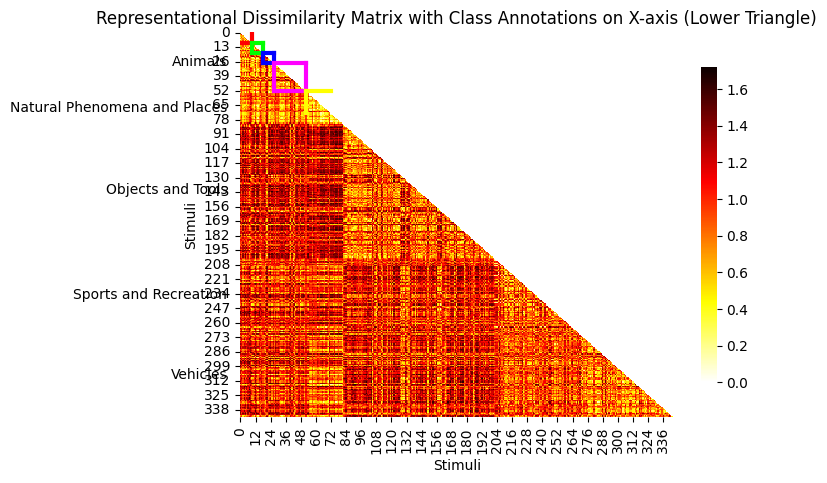

In [ ]:
stimuli_classes = list(maping_video_classes.values())
rdm = filtered_RDMs['layer_8']
mask = np.triu(np.ones_like(rdm, dtype=bool))

# Create the heatmap
f, ax = plt.subplots(figsize=(7, 5))
vmin=rdm.min();vmax=rdm.max()
sns.heatmap(rdm, mask=mask, vmin=vmin, vmax=vmax, cmap='hot_r', square=False, cbar_kws={"shrink": .82},ax=ax)

# Calculate class boundaries for annotation
unique_classes = list(pd.unique(stimuli_classes))
class_indices = {cls: [] for cls in unique_classes}
for idx, cls in enumerate(stimuli_classes):
    class_indices[cls].append(idx)

for cls, indices in class_indices.items():
    middle = int(np.mean(indices))
    ax.text(-10, middle, cls, fontsize=10, color='black', rotation=0,
                verticalalignment='center', horizontalalignment='right')


plt.plot([9.5, 9.5], [9.5, 0], color=[1, 0, 0], linestyle='-', linewidth=3)     # animal
plt.plot([9.5, 0], [9.5, 9.5], color=[1, 0, 0], linestyle='-', linewidth=3)     # animal

plt.plot([9.55, 9.55], [18.55, 9.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places
plt.plot([18.55, 9.55], [9.55, 9.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places
plt.plot([9.55, 18.55], [18.55, 18.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places
plt.plot([18.55, 18.55], [9.55, 18.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places

plt.plot([18.55, 18.55], [27.55, 18.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools
plt.plot([27.55, 18.55], [18.55, 18.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools
plt.plot([18.55, 27.55], [27.55, 27.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools
plt.plot([27.55, 27.55], [18.55, 27.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools

plt.plot([27.55, 27.55], [52.55, 27.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation
plt.plot([52.55, 27.55], [27.55, 27.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation
plt.plot([27.55, 52.55], [52.55, 52.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation
plt.plot([52.55, 52.55], [27.55, 52.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation

plt.plot([52.55, 52.55], [72.55, 52.55], color=[1, 1, 0], linestyle='-', linewidth=3)     # vehicles
plt.plot([72.55, 52.55], [52.55, 52.55], color=[1, 1, 0], linestyle='-', linewidth=3)     # vehicles

plt.xlabel('Stimuli')
plt.ylabel('Stimuli')
plt.title('Representational Dissimilarity Matrix with Class Annotations on X-axis (Lower Triangle)')
plt.show()

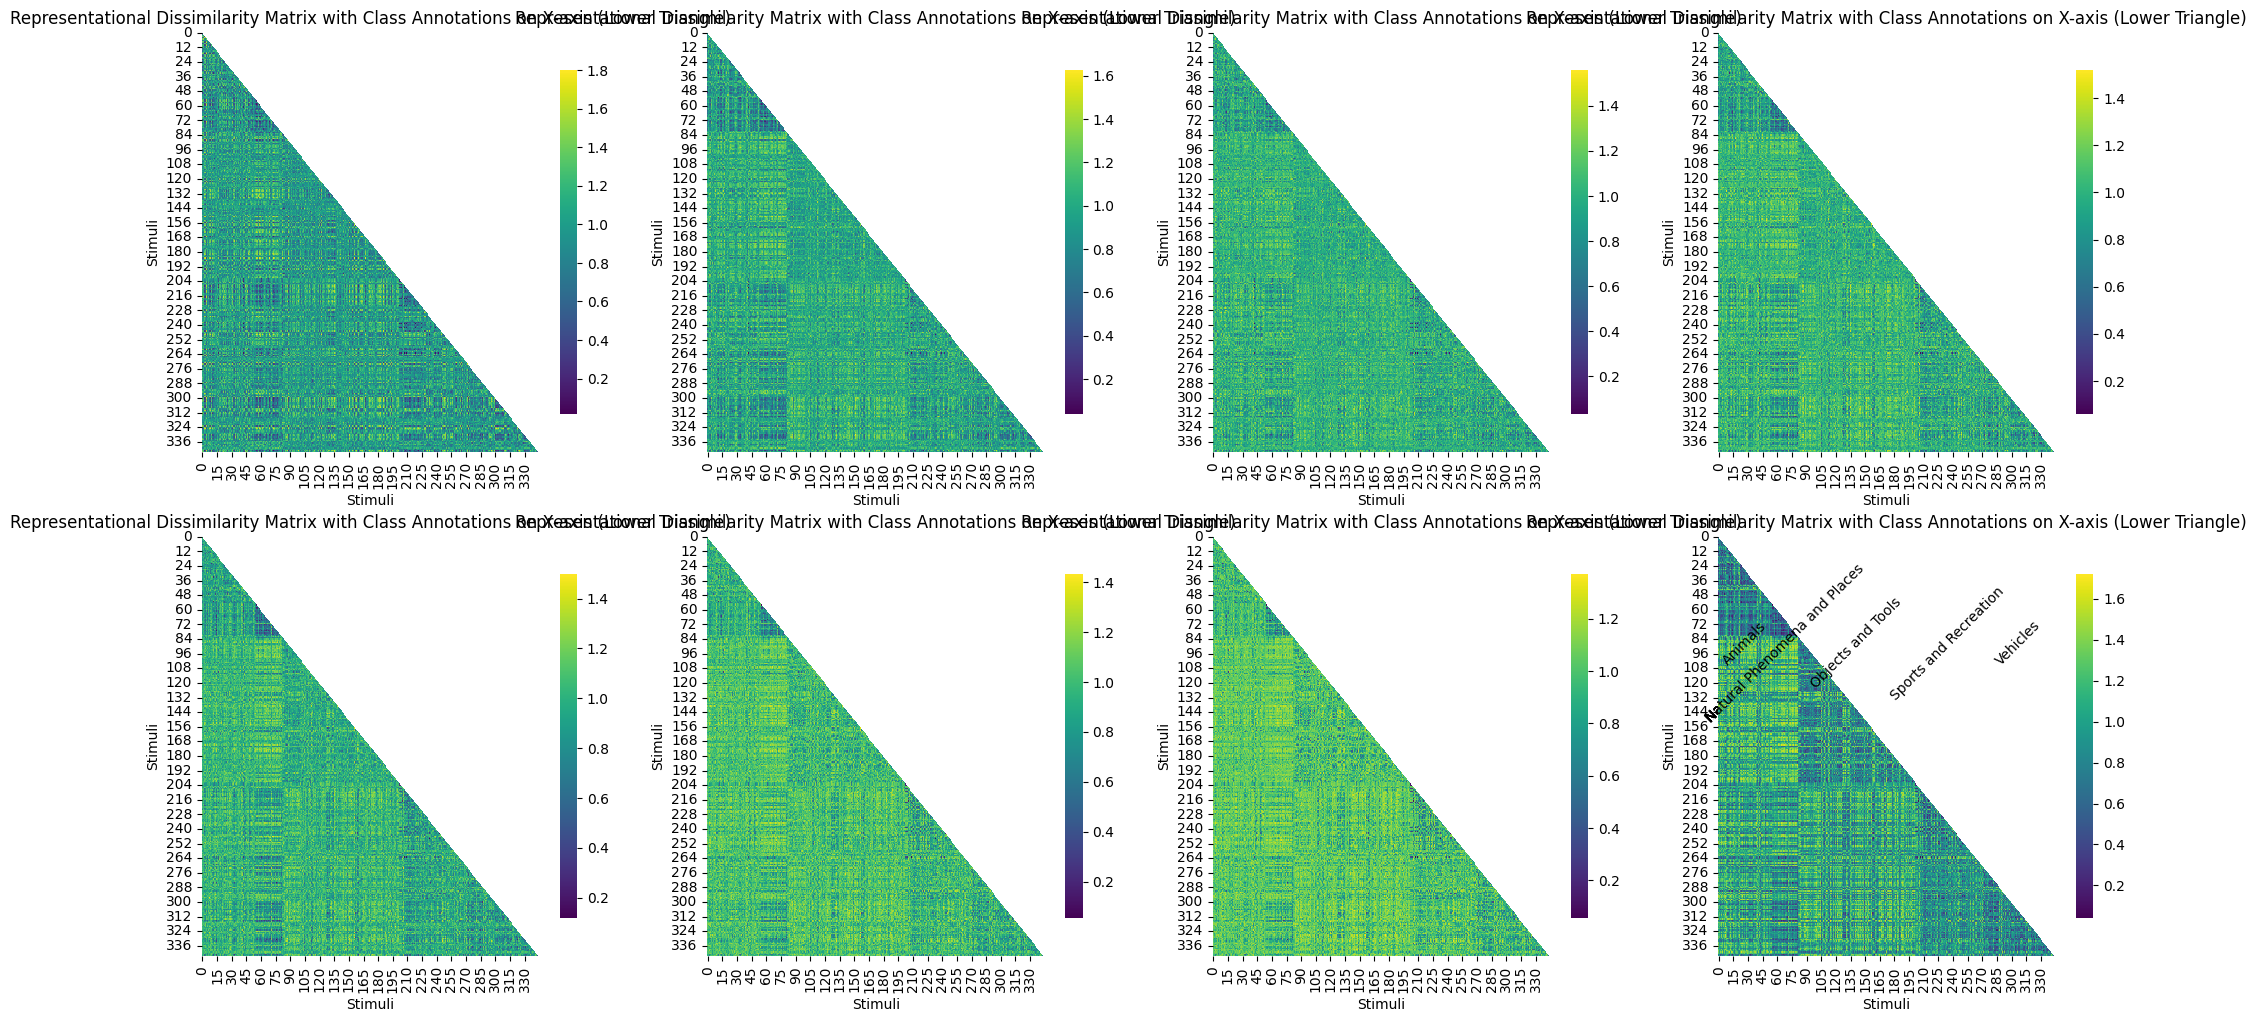

In [ ]:
def create_rdm_plot(layer,ax):
    stimuli_classes = list(maping_video_classes.values())
    rdm = filtered_RDMs[layer]
    mask = np.triu(np.ones_like(rdm, dtype=bool))
    # RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan

    # Create the heatmap
    sns.heatmap(rdm, mask=mask, cmap='viridis', square=False, cbar_kws={"shrink": .82}, ax=ax)

    # Calculate class boundaries for annotation
    unique_classes = list(pd.unique(stimuli_classes))
    class_indices = {cls: [] for cls in unique_classes}
    for idx, cls in enumerate(stimuli_classes):
        class_indices[cls].append(idx)

    # Annotate the x-axis with a single label at the center of each class
    for cls, indices in class_indices.items():
        middle = int(np.mean(indices))
        ax.text(middle, 88, cls, ha='center', va='center', fontsize=10, color='black', rotation=45, transform=plt.gca().transData)

    ax.set_xlabel('Stimuli')
    ax.set_ylabel('Stimuli')
    ax.set_title('Representational Dissimilarity Matrix with Class Annotations on X-axis (Lower Triangle)')
    # plt.show()

fig, axes = plt.subplots(2,4, figsize=(25,12))
axes = axes.flatten()
layers = [f'layer_{i}' for i in range(1,9)]
for ax,layer in zip(axes,layers):
    create_rdm_plot(layer,ax)


# def create_rdm_plot(maping_video_classes, rdm,ax):
#     stimuli_classes = list(maping_video_classes.values())
#     mask = np.triu(np.ones_like(rdm, dtype=bool))
#     sns.heatmap(rdm, mask=mask, cmap='viridis', square=False, cbar_kws={"shrink": .82}, ax=ax)

# fig, axes = plt.subplots(2,4, figsize=(25,12))
# axes = axes.flatten()
# layers = [f'layer_{i}' for i in range(1,9)]
# for ax,layer in zip(axes,layers):
#     rdm = filtered_RDMs[layer]
#     create_rdm_plot(maping_video_classes, rdm,ax)

In [ ]:
alex = pd.read_csv("/content/drive/MyDrive/neuromatch/results/rdm_values_alexnet380.csv")
fmri = pd.read_csv("/content/drive/MyDrive/neuromatch/results/rdm_values_fmri380.csv")

In [ ]:
array1= alex.sub_ROI.unique()
array2= fmri.sub_ROI.unique()
pairs = np.array(np.meshgrid(array1, array2)).T.reshape(-1, 2)
pairs

output = pd.DataFrame()
counter = 0
for pair in pairs:
    print(pair)
    alex_ind = alex[alex.sub_ROI == pair[0]].drop(columns=['index','sub_ROI']).to_numpy()
    fmri_ind = fmri[fmri.sub_ROI == pair[1]].drop(columns=['index','sub_ROI']).to_numpy()

    fmri_ind = fmri_ind[np.triu_indices_from(fmri_ind, k=1)]
    alex_ind = alex_ind[np.triu_indices_from(alex_ind, k=1)]

    pearson_corr, p_value_pearson = pearsonr(fmri_ind, alex_ind)
    spearman_corr, p_value_spearman = spearmanr(fmri_ind, alex_ind)

    data = {
            "alexnet_layer" : pair[0],
            "fmri_roi" : pair[1],
            "pearson_corr" : pearson_corr,
            "p_value_pearson" : p_value_pearson,
            # "spearman_corr" = spearman_corr,
            # "p_value_spearman" = p_value_spearman,
    }
    df = pd.DataFrame(data, index=[counter])
    counter +=1
    output = pd.concat([output, df])

output['roi'] = output.fmri_roi.str.split("_").str.get(1)
output[output.p_value_pearson < .05].sort_values(by='pearson_corr',ascending=False).to_csv("/content/drive/MyDrive/neuromatch/results/corr_results_values.csv",index=False)

['layer_1' 'sub01_V1']
['layer_1' 'sub01_V2']
['layer_1' 'sub01_V3']
['layer_1' 'sub01_V4']
['layer_1' 'sub01_LOC']
['layer_1' 'sub01_EBA']
['layer_1' 'sub01_FFA']
['layer_1' 'sub01_STS']
['layer_1' 'sub01_PPA']
['layer_1' 'sub02_V1']
['layer_1' 'sub02_V2']
['layer_1' 'sub02_V3']
['layer_1' 'sub02_V4']
['layer_1' 'sub02_LOC']
['layer_1' 'sub02_EBA']
['layer_1' 'sub02_FFA']
['layer_1' 'sub02_STS']
['layer_1' 'sub02_PPA']
['layer_1' 'sub03_V1']
['layer_1' 'sub03_V2']
['layer_1' 'sub03_V3']
['layer_1' 'sub03_V4']
['layer_1' 'sub03_LOC']
['layer_1' 'sub03_EBA']
['layer_1' 'sub03_FFA']
['layer_1' 'sub03_STS']
['layer_1' 'sub03_PPA']
['layer_1' 'sub04_V1']
['layer_1' 'sub04_V2']
['layer_1' 'sub04_V3']
['layer_1' 'sub04_V4']
['layer_1' 'sub04_LOC']
['layer_1' 'sub04_EBA']
['layer_1' 'sub04_FFA']
['layer_1' 'sub04_STS']
['layer_1' 'sub04_PPA']
['layer_1' 'sub05_V1']
['layer_1' 'sub05_V2']
['layer_1' 'sub05_V3']
['layer_1' 'sub05_V4']
['layer_1' 'sub05_LOC']
['layer_1' 'sub05_EBA']
['layer_1' '

In [ ]:
output = pd.read_csv("/content/drive/MyDrive/neuromatch/results/corr_results_values.csv")
output['subject'] = output.fmri_roi.str.split("_").str.get(0)

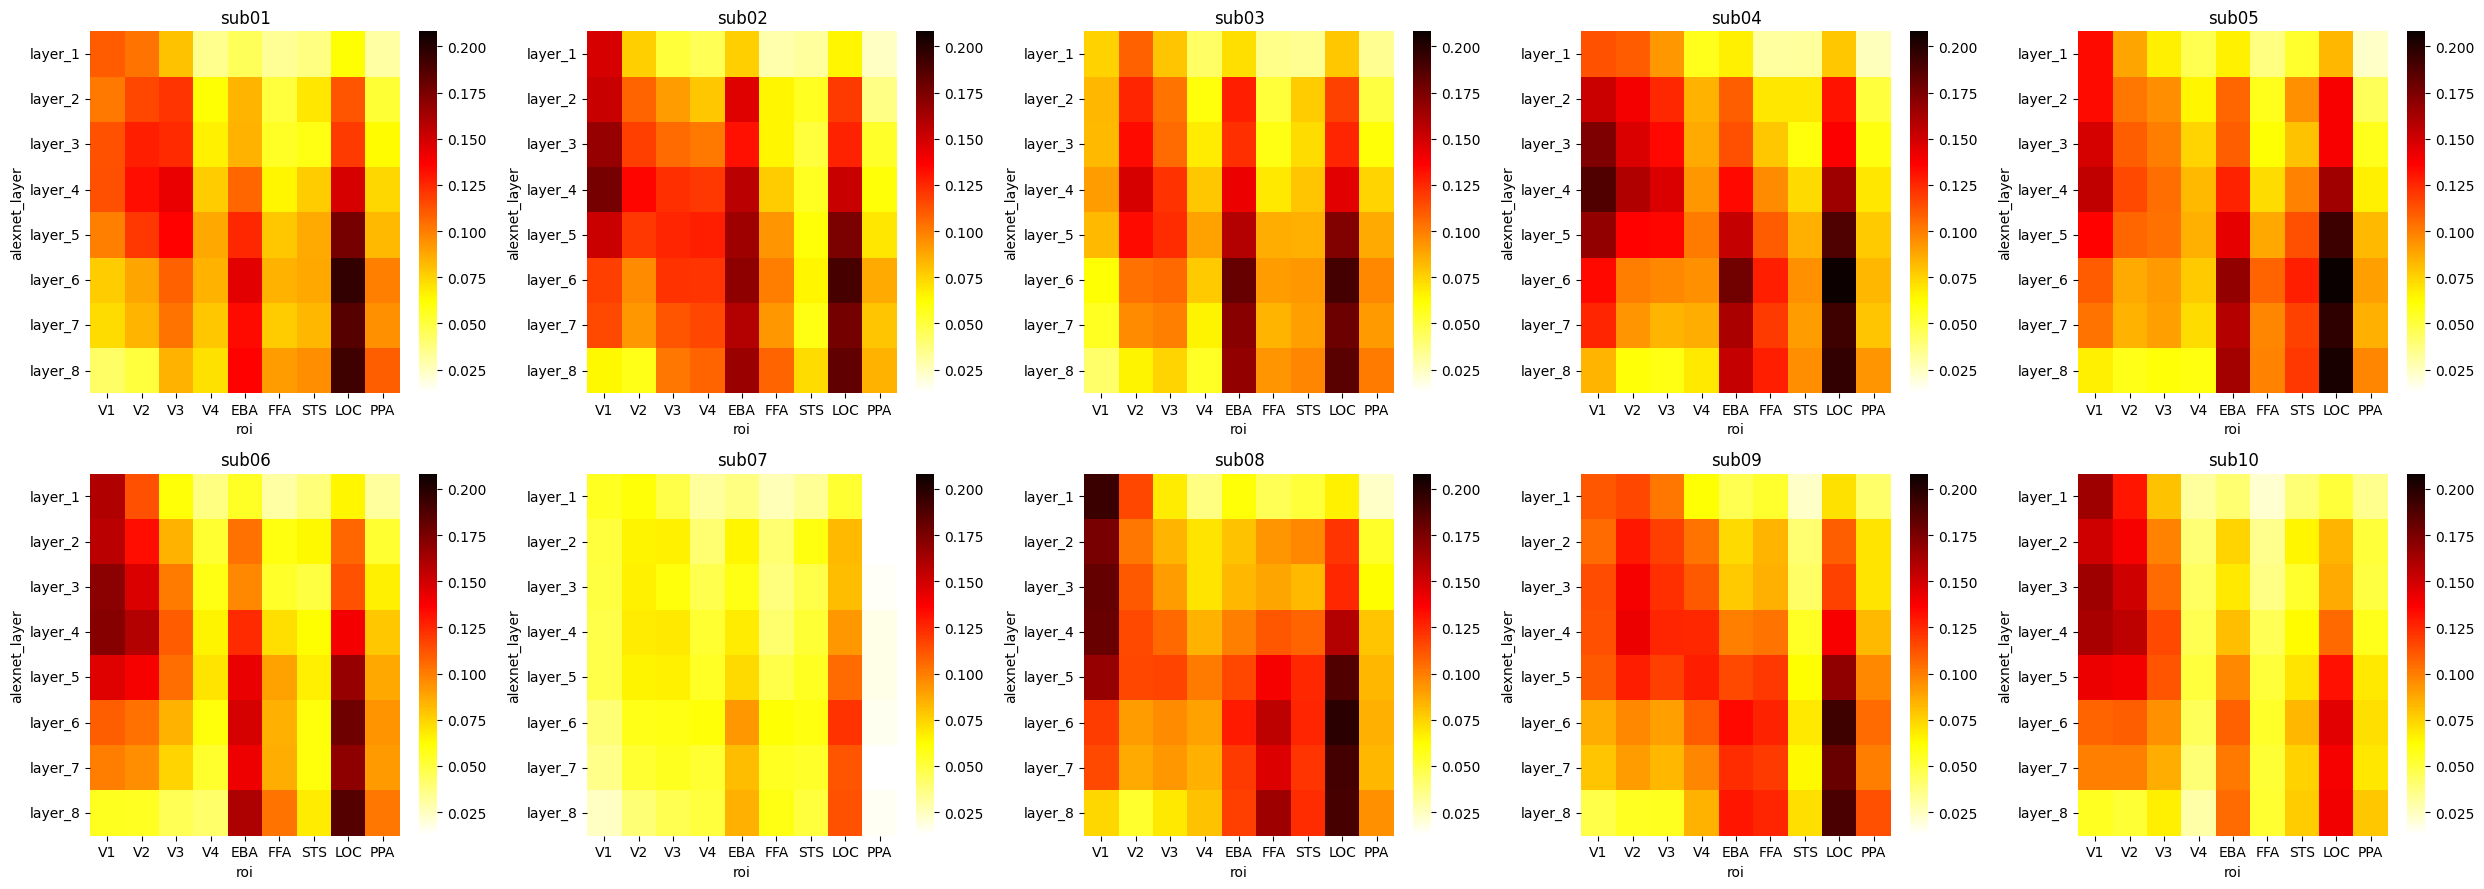

In [ ]:
fig, axes = plt.subplots(2,5,figsize=(25,9))
axes = axes.flatten()

roi_order = ['V1', 'V2', 'V3','V4','EBA','FFA', 'STS', 'LOC', 'PPA']
subjects_order = output.subject.sort_values().unique()
average_data = {}
for ax, sub in zip(axes, subjects_order):
    sub_data = output[output.subject == sub].drop(columns=['fmri_roi'])
    heatmap_df = sub_data.groupby(['alexnet_layer','roi']).pearson_corr.sum().unstack()#.reset_index()
    vmin,vmax=output.pearson_corr.min(), output.pearson_corr.max()
    try:
        reordered_data = heatmap_df[roi_order]
    except:
        reordered_data = heatmap_df[['V1', 'V2', 'V3','V4','EBA','FFA', 'STS', 'LOC']]

    sns.heatmap(reordered_data, vmin=vmin, vmax=vmax, cmap='hot_r',ax=ax)
    ax.set_title(sub)
    average_data[sub]=reordered_data.to_numpy()

plt.tight_layout()

Text(0.5, 1.0, 'Average between subjects')

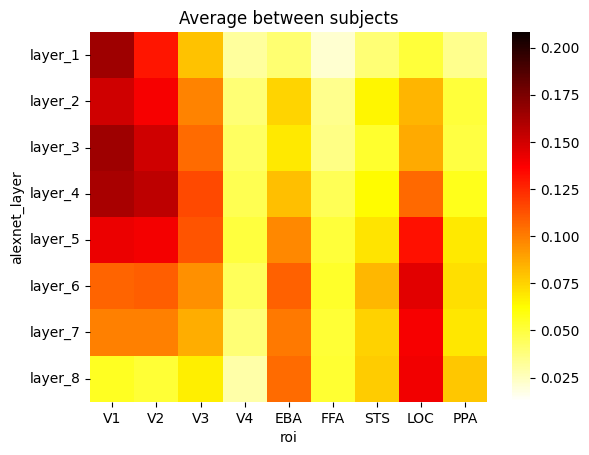

In [ ]:
# Get the size of the matrices
matrix_size = average_data['sub10'].shape

# Initialize an accumulator matrix
accumulator = np.zeros(matrix_size)

# Sum all matrices
for matrix in average_data.values():
    matrix = np.nan_to_num(matrix, nan=0)
    try:
        accumulator += matrix
    except:
        zero_array = np.zeros((8, 1))
        matrix = np.hstack((matrix, zero_array))
        accumulator += matrix

    # print(accumulator)
    # print("######################")

# Calculate the average matrix
average_matrix = accumulator / len(average_data)
heat_map = pd.DataFrame(columns =heatmap_df.columns, data = average_matrix, index=heatmap_df.index)
sns.heatmap(reordered_data, vmin=vmin, vmax=vmax, cmap='hot_r')
plt.title("Average between subjects")